In [199]:
import os
import scipy
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm.auto import tqdm

In [200]:
mdata = [scipy.io.loadmat(os.path.join('data', 'mitchell', file)) for file in os.listdir('data/mitchell')]

### Filter voxel overlap

In [201]:
participants = []
for participant in mdata:
    voxel_coords = list(map(tuple, participant['meta'][0][0]['colToCoord']))
    voxel_to_index = {}
    for voxel_coord in voxel_coords:
        index = participant['meta'][0][0]['coordToCol'][voxel_coord]
        if index != 0:
            voxel_to_index[voxel_coord] = index
    trials = participant['data']
    participants.append({
        'trials': trials,
        'voxel_to_index': voxel_to_index
    })

In [202]:
common_voxel_coordinates = set(participants[0]['voxel_to_index'].keys())
for dictionary in participants[1:]:
    common_voxel_coordinates.intersection_update(set(dictionary['voxel_to_index'].keys()))

In [203]:
mdata_common_voxels = []
for i in tqdm(range(len(participants))):
    trials_activation = participants[i]['trials']
    voxel_to_index = participants[i]['voxel_to_index']
    trials_activation_common_voxels = []
    
    for activations in trials_activation:
        voxel_to_activation = {voxel_coord: activations[0][0][index] for voxel_coord, index in voxel_to_index.items() 
                               if voxel_coord in common_voxel_coordinates}
        if i == 0:
            common_voxels_list_ordered = list(voxel_to_activation.keys())
        activations_array = np.array([voxel_to_activation[voxel_coord] for voxel_coord in common_voxels_list_ordered])
        
        trials_activation_common_voxels.append(activations_array)
    mdata_common_voxels.append(trials_activation_common_voxels)

100%|██████████| 9/9 [00:20<00:00,  2.24s/it]


### Voxels atlas

In [204]:
given_vox_atlas = scipy.io.loadmat("../mitchel_matlab/functions/ccbi_aal_atlas.mat")

In [205]:
resampled_atlas_path = "data/atlas_resampled_to_results.nii.gz"
resampled_atlas = nib.load(resampled_atlas_path)
resampled_atlas_data = resampled_atlas.get_fdata()

### Create voxels-nouns matrix (13189 x 60)

In [206]:
arrays = {}
for i in tqdm(range(len(mdata))):
    for item in mdata[i]['info'][0]:
        word = item[2][0]
        if word in arrays:
            arrays[word].append(mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]])
        else:
            arrays[word] = [mdata_common_voxels[i][np.where(mdata[i]['info'][0] == item)[0][0]]]

100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


In [207]:
averaged_arrays = {}
for word in arrays.keys():
    averaged_arrays[word] = np.mean(np.stack(arrays[word]), axis=0)

In [208]:
df_voxel_noun = pd.DataFrame.from_dict(averaged_arrays)

In [209]:
df_voxel_noun.head()

,refrigerator,barn,bell,key,window,screwdriver,church,desk,cow,knife,...,door,leg,carrot,watch,table,chimney,bed,fly,dog,telephone
0,0.211282,-0.032681,0.075107,0.065357,0.098850,0.017014,0.082626,0.194088,0.226367,0.116644,...,-0.306202,0.053146,-0.238628,0.078315,0.227752,0.043533,0.066288,0.040559,-0.077895,-0.047540
1,0.107987,-0.030083,-0.019675,0.052926,0.030485,0.031289,-0.021650,0.073874,0.147577,0.233340,...,-0.316916,-0.012744,-0.090086,-0.047209,0.103996,0.064340,0.142248,0.079571,-0.042438,-0.003700
2,0.077878,0.099431,-0.133270,0.109347,0.115465,0.113053,0.100633,0.052981,0.213665,0.075284,...,-0.146221,0.102715,0.032594,-0.030453,0.117935,0.074295,0.122762,0.091939,0.005176,-0.005997
3,0.057567,0.199245,0.024434,0.221457,0.087734,-0.015771,-0.070153,0.058005,0.270423,0.412821,...,0.068590,0.217701,0.013154,0.117254,-0.140920,0.137188,0.272694,-0.010715,0.179643,0.077197
4,0.024377,-0.031948,-0.046189,0.091493,-0.073756,-0.148000,-0.202486,0.052354,0.096579,0.366777,...,-0.213800,-0.022064,-0.107096,-0.049962,-0.104663,-0.150098,0.164862,-0.159270,-0.007124,-0.048999


### Create nouns-sem_featuers matrix (60 x 25)

In [210]:
sem_features_file = os.path.join("data","mitchell_semantic_raw.txt")
semantic_features = {}
with open(sem_features_file, 'r') as f:
    lines = f.readlines()
    word = None
    for line in lines:
        if len(line) >= 5:
            if "Features for" in line:
                if word and len(semantic_features[word]['features']) < 25: del semantic_features[word] 
                word = line.split("<a name=\"")[1].split("\"")[0]
                semantic_features[word] = { "features": [], "values": []}
            elif word:
                feature_name = line.split()[0]
                val = float(line.split("(")[1].split(")")[0])
                semantic_features[word]["features"].append(feature_name)
                semantic_features[word]["values"].append(val)

In [211]:
df_noun_feature = pd.DataFrame()
for noun, info in semantic_features.items():
    temp_df = pd.DataFrame({
        'feature': info['features'],
        'value': info['values'],
        'noun': noun})
    df_noun_feature = pd.concat([df_noun_feature, temp_df], ignore_index=True)

df_noun_feature = df_noun_feature.pivot(columns='feature', values='value', index='noun')

In [212]:
df_noun_feature.head()

feature,approach,break,clean,drive,eat,enter,fear,fill,hear,lift,...,push,ride,rub,run,say,see,smell,taste,touch,wear
noun,,,,,,,,,,,,,,,,,,,,,
airplane,0.048,0.028,0.019,0.023,0.024,0.056,0.019,0.032,0.066,0.072,...,0.024,0.918,0.000,0.052,0.201,0.221,0.005,0.000,0.048,0.001
ant,0.023,0.017,0.132,0.010,0.062,0.016,0.005,0.005,0.016,0.016,...,0.000,0.015,0.006,0.944,0.156,0.198,0.000,0.006,0.005,0.003
apartment,0.009,0.064,0.238,0.070,0.012,0.210,0.002,0.080,0.021,0.024,...,0.002,0.007,0.000,0.075,0.093,0.200,0.036,0.000,0.002,0.000
arch,0.060,0.047,0.185,0.075,0.035,0.032,0.024,0.054,0.012,0.053,...,0.004,0.018,0.007,0.129,0.244,0.474,0.000,0.000,0.127,0.015
arm,0.019,0.432,0.021,0.071,0.008,0.024,0.005,0.026,0.007,0.548,...,0.084,0.010,0.030,0.103,0.450,0.132,0.001,0.002,0.206,0.048


### Glove embeddings matrix (60 x 300)

In [213]:
glove_file = os.path.join("data", "glove.6B","glove.6B.300d.txt")
with open(glove_file, 'r') as f:
    lines = f.readlines()

In [214]:
glove_embeddings = {}
for line in lines:
    word = line.split()[0]
    if word in averaged_arrays.keys():
        glove_embeddings[word] = line.split()[1:]

In [215]:
df_noun_glove = pd.DataFrame.from_dict(glove_embeddings, orient='index')

In [216]:
df_noun_glove.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
house,-0.3707,-0.081209,-0.44626,0.097395,0.19829,-0.041232,0.21189,0.22369,-0.59915,-1.3556,...,-0.39222,-0.1203,0.37379,0.10174,-0.074873,-0.0099385,-0.28702,0.030515,-0.33168,1.0232
cup,0.2853,1.1604,0.43643,-0.79668,0.23233,0.22757,-0.27564,0.26498,0.023262,-0.46187,...,-0.51124,0.44536,-0.39929,0.15475,0.85655,-0.22964,0.13523,-0.39542,0.1836,0.24845
church,-0.65236,-0.74691,-0.71397,-0.0059515,-0.25791,-0.21593,-0.35199,-0.11603,-0.056036,-1.2818,...,-0.38289,-0.15445,0.22412,0.65258,0.18425,0.014896,-0.15189,0.30928,0.10806,-0.12449
car,0.46443,0.3773,-0.21459,-0.50768,-0.24576,0.08134,0.10145,0.25155,-0.36152,-1.603,...,0.19966,-0.40979,-0.10325,-0.04361,0.17564,0.65709,-0.09986,0.49107,0.28215,0.34554
key,0.20243,0.088567,0.047715,-0.67813,0.40773,-0.23219,-0.31256,-0.011064,-0.61183,-1.55,...,0.1642,-0.51675,0.20555,0.15859,0.038283,1.0802,-0.14723,-0.8141,-1.0227,0.16732


### Linear Regression

#### Compute coefficients

In [217]:
from sklearn.linear_model import LinearRegression

In [218]:
lin_reg = LinearRegression()

In [219]:
X = df_noun_feature
y = df_voxel_noun

In [220]:
df_coefficients = pd.DataFrame(index=range(y.shape[0]), columns=X.columns)
df_coefficients.index.name = 'voxel'

In [221]:
for i in tqdm(range(y.shape[0])):
    lin_reg.fit(X, y.iloc[i])
    df_coefficients.iloc[i] = lin_reg.coef_
df_coefficients['coordinates'] = common_voxels_list_ordered
df_coefficients['brain_region'] = {}

100%|██████████| 13189/13189 [00:08<00:00, 1572.63it/s]


#### Compute R^2

In [222]:
df_score = pd.DataFrame(index=range(y.shape[0]), columns=['R^2'])
df_score.index.name = 'voxel'

In [223]:
for i in tqdm(range(y.shape[0])):
    r_2 = lin_reg.score(X, y.iloc[i])
    df_score.iloc[i] = r_2
df_score['coordinates'] = common_voxels_list_ordered

100%|██████████| 13189/13189 [00:06<00:00, 1987.80it/s]


In [224]:
# df_score.head()

### Lasso Regression

In [225]:
# from sklearn.linear_model import Lasso

In [226]:
# lasso_model = Lasso(alpha=1.0)  # Adjust alpha for regularization strength
# voxel_coordinates = mdata_common_voxels[0][0][0]

In [227]:
# X = df_noun_feature
# y = df_voxel_noun

In [228]:
# df_lasso_coefficients = pd.DataFrame(index=range(y.shape[0]), columns=X.columns)
# df_lasso_coefficients.index.name = 'voxel'

# for i in tqdm(range(y.shape[0])):
#     lasso_model.fit(X, y.iloc[i])
#     df_lasso_coefficients.iloc[i] = lasso_model.coef_

# df_lasso_coefficients['coordinates'] = voxel_coordinates

In [229]:
# df_lasso_coefficients.loc[0]['see']

### Brain images

#### plot model coefficients

In [230]:
from nilearn import plotting
from nilearn.plotting import plot_glass_brain

In [231]:
volume_shape = resampled_atlas_data.shape
brain_volume = np.zeros(volume_shape)

In [232]:
for index, row in df_coefficients.iterrows():
    coordinates = row['coordinates']
    x, y, z = coordinates[0], coordinates[1], coordinates[2]
    brain_volume[x, y, z] = row['see']

In [233]:
affine = np.array([[-3.125, 0,     0,   81.250],
                   [0,     3.125, 0, -115.625],
                   [0,     0,     6,  -54.000],
                   [0,     0,     0,    1.000]])

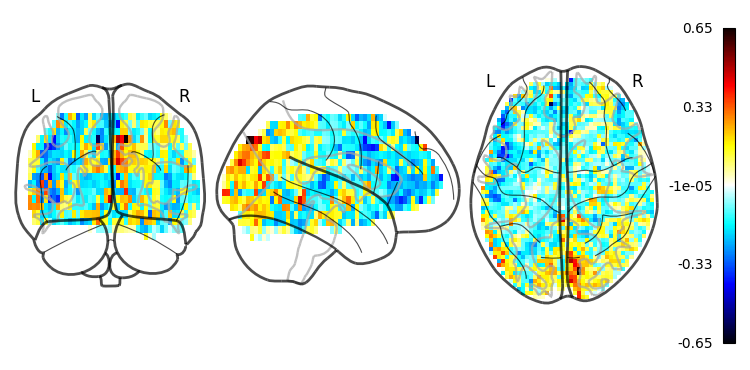

In [234]:
nii_image = nib.Nifti1Image(brain_volume, affine=affine)
plot_glass_brain(nii_image, display_mode='ortho', colorbar=True, plot_abs=False)

#### plot model's R^2

In [235]:
brain_volume_r_2 = np.zeros(volume_shape)

In [236]:
for index, row in df_score.iterrows():
    coordinates = row['coordinates']
    x, y, z = coordinates[0], coordinates[1], coordinates[2]
    brain_volume_r_2[x, y, z] = row['R^2']

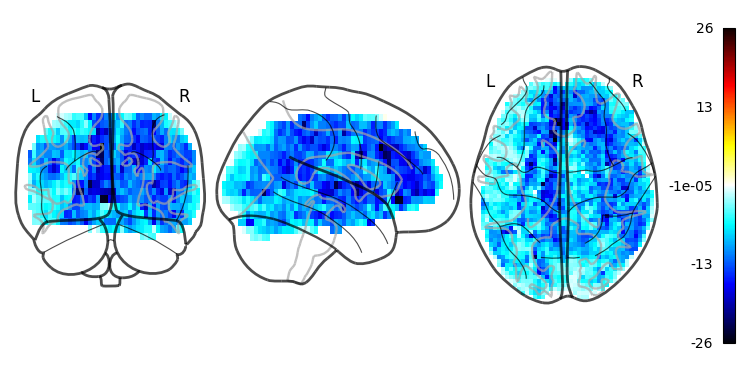

In [237]:
nii_image_r_2 = nib.Nifti1Image(brain_volume_r_2, affine=affine)
plot_glass_brain(nii_image_r_2, display_mode='ortho', colorbar=True, plot_abs=False)

In [238]:
# import matplotlib.pyplot as plt

In [239]:
# plt.hist(df_score['R^2'].astype(float), bins=100)
# plt.xlabel('R^2 value')
# plt.ylabel('Frequency')
# plt.title('Distribution of R^2 values')
# plt.show()

In [240]:
# df_score[df_score['R^2'] > 0]

In [241]:
# plt.hist(df_score[df_score['R^2'] > 0]['R^2'].astype(float), bins=100)
# plt.xlabel('R^2 value')
# plt.ylabel('Frequency')
# plt.title(f"Distribution of R^2 values, total: {df_score[df_score['R^2'] > 0].shape[0]}")
# plt.show()

### Cluster

In [242]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt

In [243]:
scaler = StandardScaler()
df_feature_see = df_coefficients[['see', 'coordinates']]

In [244]:
X_scaled = scaler.fit_transform(df_feature_see[['see']])

In [245]:
Z = linkage(X_scaled, method='ward')

In [246]:
# plt.figure(figsize=(7, 4))
# dendrogram(Z, truncate_mode='level', p=5)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Voxel index or (cluster size)')
# plt.ylabel('Distance')
# plt.show()

In [247]:
n_clusters = 7
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(X_scaled)
df_feature_see['Cluster'] = cluster_labels

/var/folders/xg/v6f13_951rs60k5l7yzhm1km0000gn/T/ipykernel_19924/324258184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_see['Cluster'] = cluster_labels


In [248]:
df_feature_see['Cluster'].value_counts()

Cluster
2    4673
4    2411
5    2386
3    1744
6     799
0     652
1     524
Name: count, dtype: int64

In [249]:
cluster_means = df_feature_see.groupby('Cluster')['see'].mean()
print(cluster_means)

highest_activity_cluster = cluster_means.idxmax()
print(f'The cluster with the highest activity is: {highest_activity_cluster}')

Cluster
0    0.178393
1   -0.203348
2   -0.018073
3    0.083047
4   -0.075311
5    0.033041
6   -0.127077
Name: see, dtype: object
The cluster with the highest activity is: 0


/var/folders/xg/v6f13_951rs60k5l7yzhm1km0000gn/T/ipykernel_19924/1824742512.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='see', data=df_feature_see, palette='viridis')


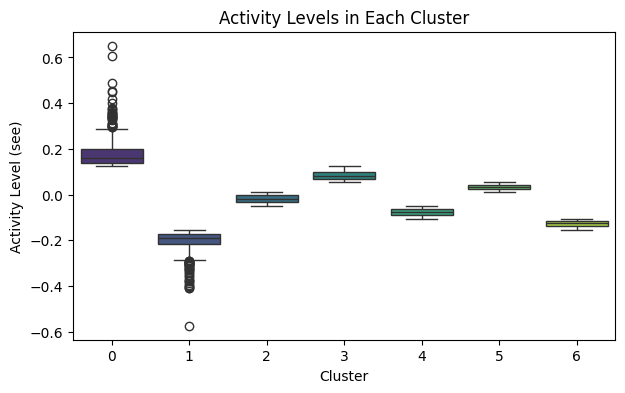

In [250]:
# Visualize the distribution of activity levels in each cluster
plt.figure(figsize=(7, 4))
sns.boxplot(x='Cluster', y='see', data=df_feature_see, palette='viridis')
plt.title('Activity Levels in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Activity Level (see)')
plt.show()

#### plot cluster

In [251]:
from collections import Counter

In [286]:
volume_shape = resampled_atlas_data.shape
brain_volume_cluster = np.zeros(volume_shape)

In [287]:
vox_coord_to_brain_regions = {}
for index, row in df_feature_see.iterrows():
    if row['Cluster'] == highest_activity_cluster:
        coordinates = row['coordinates']
        x, y, z = coordinates[0], coordinates[1], coordinates[2]
        vox_coord_to_brain_regions[(x, y, z)] = given_vox_atlas['label'][given_vox_atlas['id'] == [new_atlas.get_fdata()[x][y][z]]][0][0][0][0]
        if vox_coord_to_brain_regions[(x, y, z)] == 'Cuneus_R':
            brain_volume_cluster[x, y, z] = row['see']

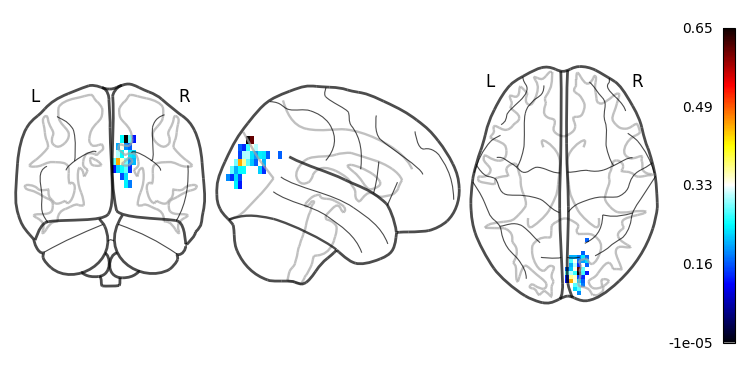

In [288]:
nii_image = nib.Nifti1Image(brain_volume_cluster, affine=affine)
plot_glass_brain(nii_image, display_mode='ortho', colorbar=True, plot_abs=False)

In [256]:
Counter(vox_coord_to_brain_regions.values())

Counter({'Cuneus_R': 84,
         'Precuneus_R': 38,
         'Calcarine_R': 29,
         'Occipital_Mid_L': 29,
         'Temporal_Mid_L': 25,
         'Lingual_R': 24,
         'Frontal_Mid_R': 23,
         'Occipital_Sup_R': 19,
         'Temporal_Sup_L': 16,
         'Cerebelum_6_L': 14,
         'Fusiform_R': 14,
         'Occipital_Mid_R': 14,
         'Cuneus_L': 14,
         'Not_labelled': 13,
         'Occipital_Sup_L': 13,
         'Frontal_Mid_L': 12,
         'Angular_L': 12,
         'Frontal_Sup_R': 11,
         'Temporal_Inf_R': 10,
         'Occipital_Inf_R': 10,
         'Calcarine_L': 10,
         'Vermis_4_5': 10,
         'Frontal_Sup_L': 10,
         'Occipital_Inf_L': 9,
         'Parietal_Inf_R': 9,
         'Cerebelum_6_R': 8,
         'Temporal_Mid_R': 8,
         'Frontal_Sup_Medial_L': 8,
         'Angular_R': 8,
         'Postcentral_L': 8,
         'Cerebelum_Crus1_L': 7,
         'Hippocampus_R': 7,
         'Lingual_L': 7,
         'Temporal_Sup_R': 7,
 

### RDM

#### cluster voxels x nouns

In [259]:
from scipy.spatial.distance import pdist, squareform

In [260]:
cluster_voxel_ids = df_feature_see[df_feature_see['Cluster'] == highest_activity_cluster].index.values.tolist()

In [261]:
df_noun_voxels_highest_cluster = df_voxel_noun.iloc[cluster_voxel_ids].T

In [262]:
df_noun_voxels_cluster_sorted = df_noun_voxels_highest_cluster.sort_index()

In [263]:
# df_noun_voxels_cluster_sorted

In [264]:
# df_noun_voxels_highest_cluster.to_csv("/Users/gosha/Desktop/Internship/coding/semantic-dimensions-in-brain/output/df_noun_voxels_highest_cluster.csv")

In [265]:
dissimilarity_matrix_voxels = pdist(df_noun_voxels_cluster_sorted, metric='cosine')

In [266]:
dissimilarity_matrix_voxels

array([0.7011568 , 0.16243213, 0.16332861, ..., 0.35761553, 0.25720761,
       0.32139097])

In [267]:
# rdm_matrix_voxels = squareform(dissimilarity_matrix_voxels)

In [268]:
# rdm_df_voxels = pd.DataFrame(rdm_matrix_voxels, index=df_noun_voxels_highest_cluster.index,
#                              columns=df_noun_voxels_highest_cluster.index)

In [269]:
# plt.figure(figsize=(20, 15))
# sns.heatmap(rdm_df, cmap='viridis', annot=True)
# plt.title('Representational Dissimilarity Matrix (RDM) using Cosine Similarity')
# plt.show()

#### Glove x noun

In [270]:
from scipy.stats import pearsonr, spearmanr

In [271]:
# df_noun_glove.to_csv("/Users/gosha/Desktop/Internship/coding/semantic-dimensions-in-brain/output/df_noun_glove.csv")

In [272]:
df_noun_glove_sorted = df_noun_glove.sort_index()

In [273]:
# df_noun_glove_sorted

In [274]:
dissimilarity_matrix_glove = pdist(df_noun_glove_sorted, metric='cosine')

In [275]:
# rdm_matrix_glove = squareform(dissimilarity_matrix_glove)

In [276]:
# rdm_df_glove = pd.DataFrame(rdm_matrix_glove, index=df_noun_glove.index, columns=df_noun_glove.index)

In [277]:
# plt.figure(figsize=(20, 15))
# sns.heatmap(rdm_df_glove, cmap='viridis', annot=True)
# plt.title('Representational Dissimilarity Matrix (RDM) using Cosine Similarity')
# plt.show()

### compute matrix similarity

In [278]:
# flat_rdm1 = rdm_matrix_voxels[np.triu_indices_from(rdm_matrix_voxels, k=1)]
# flat_rdm2 = rdm_matrix_glove[np.triu_indices_from(rdm_matrix_glove, k=1)]

In [279]:
pearson_corr, _ = pearsonr(dissimilarity_matrix_voxels, dissimilarity_matrix_glove)
print(f'Pearson correlation: {pearson_corr}')

spearman_corr, _ = spearmanr(dissimilarity_matrix_voxels, dissimilarity_matrix_glove)
print(f'Spearman correlation: {spearman_corr}')

Pearson correlation: 0.047642430458035866
Spearman correlation: 0.0708123138085984


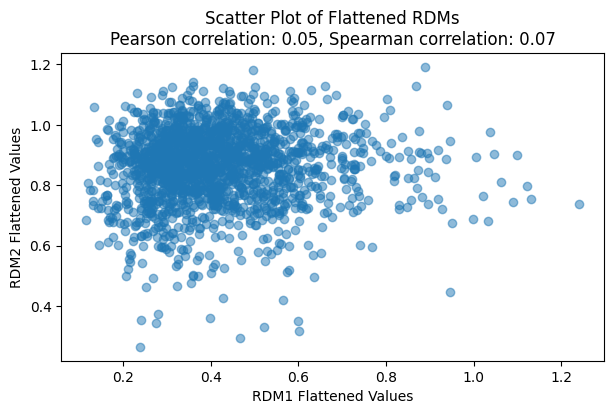

In [280]:
plt.figure(figsize=(7, 4))

# Scatter plot of the flattened RDMs
plt.scatter(dissimilarity_matrix_voxels, dissimilarity_matrix_glove, alpha=0.5)
plt.xlabel('RDM1 Flattened Values')
plt.ylabel('RDM2 Flattened Values')
plt.title(f'Scatter Plot of Flattened RDMs\nPearson correlation: {pearson_corr:.2f}, Spearman correlation: {spearman_corr:.2f}')
plt.show()

In [281]:
import statistics

In [282]:
statistics.mean([-0.01619818364434202, 0.12511973420716757, 0.04890969886192777, 0.09134019354097357,
                0.03413031290790372, 0.1362668170088834, -0.08136567530702185, 0.024682222040188745,
                -0.01233796624467425])

0.03894968370788963

0

Pearson correlation: -0.01619818364434202
Spearman correlation: -0.01551972324155002

1

Pearson correlation: 0.12511973420716757
Spearman correlation: 0.13081559414069735

2

Pearson correlation: 0.04890969886192777
Spearman correlation: 0.10028987772255624

3

Pearson correlation: 0.09134019354097357
Spearman correlation: 0.0823364125070038

4

Pearson correlation: 0.03413031290790372
Spearman correlation: 0.02732492401403431

5

Pearson correlation: 0.1362668170088834
Spearman correlation: 0.15398962289981913

7

Pearson correlation: -0.08136567530702185
Spearman correlation: -0.06746961244391607

7

Pearson correlation: 0.024682222040188745
Spearman correlation: 0.03608228650908757

8

Pearson correlation: -0.01233796624467425
Spearman correlation: -0.02483800445594764